<a href="https://www.kaggle.com/code/jorgeluiscruzquispe/nn-modelhydro-inc?scriptVersionId=190684287" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## <div style="color:#fff;display:fill;justify-content: center;border-radius:10px;background-color:#3498db;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">Neural Network test for Hydrological Model</div>

Uso de información satelital para la predicción de caudales 


<div style="display: flex; flex-direction: column; align-items: center; gap: 20px; text-align: center; margin: 0 auto; max-width: 700px;">
    <div>
        <img src="https://www.uni-potsdam.de/fileadmin/projects/cosmicsense/migrated_contents/HM_Grafik_B.Fersch_typo_3_01.png" alt="Imagen 1" style="max-height: 200px; width: auto;">
        <p style="margin: 0; font-weight: bold;">hydrological model</p>
    </div>
    <div>
        <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" alt="Imagen 2" style="max-height: 200px; width: auto;">
        <p style="margin: 0; font-weight: bold;">neural network model</p>
    </div>
</div>


## <div style="color:#fff;display:fill;border-radius:10px;background-color:#6BB1CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 📄 Table of Contents</div>

* [1- Libraries](#section-1)
* [2- Functions](#section-2)
* [3- Study zone](#section-3)
* [4- Time parameters to download and available information](#section-4) 
* [5- Precipitation - download - display](#section-5)
* [6- Evapotranspiration - download - display](#section-6) 
* [7- Soil moiusture - download - display](#section-7) 
* [8- ARIMA](#section-8) 
* [9- Neural network - assembly - prediction](#section-9) 

<a id="section-1"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#6BB1CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 1. Libraries</div>

In [1]:
!pip install -q geemap pysheds pmdarima

In [2]:
import geemap.foliumap as geemap
import geemap.colormaps as cmap
from geemap import common as cm
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from shapely import geometry, ops
from shapely.geometry import shape, Point
import pysheds
from pysheds.grid import Grid
from geojson import Feature, FeatureCollection
import rasterio as rio
import geopandas as gpd
import os
import glob
import ee
import ipywidgets as widgets

import pmdarima as pm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

2024-08-01 03:54:59.226390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 03:54:59.226529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 03:54:59.385313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AcvDMrCUfELR0hgvW_PALdXSlWQlQGkhxe0_q836I_n43uLaytbbO7QTrWE



Successfully saved authorization token.


<a id="section-2"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#6BB1CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 2. Functions</div>

In [4]:
def basin_delimitation(mosaic_dem, longitude, latitude, density = 2000):
    """basin delimitation
    mosaic_dem: dem
    longitude: longitude
    latitude: latitude
    density: density
    """
    grid = Grid.from_raster(mosaic_dem)
    dem = grid.read_raster(mosaic_dem)
    pit_filled_dem = grid.fill_pits(dem)
    flooded_dem = grid.fill_depressions(pit_filled_dem)
    inflated_dem = grid.resolve_flats(flooded_dem)
    dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
    acc = grid.accumulation(fdir, dirmap=dirmap)
    x_snap, y_snap = grid.snap_to_mask(acc > 1000, (longitude, latitude))
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate')
    grid.clip_to(catch)
    clipped_catch = grid.view(catch)
    branches = grid.extract_river_network(fdir, acc > density, dirmap=dirmap)
    shapes = grid.polygonize()
    # geodataframe catchment
    catchment_polygon = ops.unary_union([geometry.shape(shape) for shape, value in shapes])
    gdf_catchment_polygon = gpd.GeoDataFrame(geometry=[catchment_polygon])
    gdf_catchment_polygon.crs = 'EPSG:4326'  
    # geodataframe branches
    geometries = [shape(feature['geometry']) for feature in branches['features']]
    gdf_branches = gpd.GeoDataFrame(geometry=geometries)
    gdf_branches.crs = 'EPSG:4326'  
    # geodataframe point
    gdf_point = gpd.GeoDataFrame(geometry = [Point(longitude, latitude)])
    gdf_point.crs = 'EPSG:4326'  
    gdf_catchment_polygon = geemap.geopandas_to_ee(gdf_catchment_polygon)
    gdf_branches = geemap.geopandas_to_ee(gdf_branches)
    gdf_point = geemap.geopandas_to_ee(gdf_point)
    return gdf_catchment_polygon, gdf_branches, gdf_point
    
def df_convert(img_collection, geometry, scale = 5000):
    """reduction of images to dataframe
    img_collection: data extraction result by date
    geometry: bounded basin
    scale: scala to consider
    """
    list_img_flat = ee.List(img_collection.flatten())
    list_img_col = ee.ImageCollection.fromImages(list_img_flat)
    list_img = list_img_col.toList(list_img_col.size())
    # list values images
    range_values = []; range_date = []
    # iteration image
    for i in range(0, list_img_col.size().getInfo()):
        list_image_i = list_img.get(i)
        image_i = ee.Image(list_image_i)
        mean_image = image_i.reduceRegion(reducer = ee.Reducer.mean(), geometry = geometry, scale = scale)
        range_values.append(list(mean_image.getInfo().values())[0])
        month_val = list_image_i.getInfo()["properties"]["month"]
        year_val = list_image_i.getInfo()["properties"]["year"]
        time_string = f"{year_val}-{month_val}-01"
        range_date.append(time_string)
    # dataframe result
    df = pd.DataFrame({"date": pd.to_datetime(range_date), list_image_i.getInfo()["bands"][0]["id"]: range_values}).set_index("date")
    return df

def download_dem(selected, basin_name):
    """parameters
    selected: basin
    basin_name: output name
    """
    cartas_intersectadas = ee.FeatureCollection('users/jorgeluiscruzquispe7/Cuadro_Empalme100k').filterBounds(selected.geometry())

    poligonos = cartas_intersectadas.toList(cartas_intersectadas.size())

    numero = poligonos.length().getInfo()

    for n in range(0, numero):
        dem_carta_salida = f"{basin_name}_{str(n)}.tif"
        poligono = ee.Feature(poligonos.get(n))
        geemap.ee_export_image(srtm4.clip(poligono.geometry()), dem_carta_salida, region = poligono.geometry())

    src_files_to_mosaic = []

    for dem_carat in glob.glob(f'{basin_name}_*.tif'):
        src_files_to_mosaic.append(rio.open(dem_carat))

    mosaic, out_trans = merge(src_files_to_mosaic)

    output_meta = rio.open(f'{basin_name}_0.tif').meta.copy()
    
    output_meta.update(
        {"driver": "GTiff",
         "height": mosaic.shape[1],
         "width": mosaic.shape[2],
         "transform": out_trans})

    with rio.open(f"{basin_name}.tif", 'w', **output_meta) as m:
        m.write(mosaic)

    for n in glob.glob(f'{basin_name}_*.tif'):
        os.remove(n) 
        
    return 

def parameters_datasets(*args):
    list1 = []
    for i in args:
        list1.append(len(cm.search_ee_data(i, source="all")))
    return pd.DataFrame(data = [list1], columns = args, index = ["all"]).transpose()

def img_download(list_img_extract, roi, scale = 30, output_name = "img"):
    for i in range(0, list_img_extract.length().getInfo()):
        img_collection = list_img_extract.get(i)
        list_img_col = ee.ImageCollection.fromImages(img_collection).sum().clip(roi)
        geemap.ee_export_image(list_img_col.unmask(sameFootprint = False), 
                               filename = f"{output_name}_{i}.tif", scale = scale, region = roi, file_per_band=False)

    return 

def plot_image(title, subplots_por_fila, lista_pp, width = 15, high = 2.5):
    subplots_por_fila = subplots_por_fila
    num_total = len(lista_pp)
    num_filas = -(-num_total // subplots_por_fila)  
    num_columnas = min(subplots_por_fila, num_total)

    fig, axs = plt.subplots(num_filas, num_columnas, figsize = (width, num_filas * high))

    for i, ruta_tiff in enumerate(lista_pp):
        fila = i // subplots_por_fila
        columna = i % subplots_por_fila

        with rio.open(ruta_tiff) as src:
            img = src.read(1)  
            im = axs[fila, columna].imshow(img, cmap = 'jet', vmin = img.min(), vmax = img.max())
            axs[fila, columna].set_title(f'Year {i + int(start.format().getInfo()[:4])}')
            fig.colorbar(im, ax = axs[fila, columna], orientation = 'horizontal', shrink = 0.7)

    for j in range(num_columnas, subplots_por_fila):
        fig.delaxes(axs[num_filas - 1, j])
    
    plt.suptitle(title)
    
    plt.tight_layout()  
    
    plt.show()        
    
    return 

<a id="section-3"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#6BB1CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 3. Study zone</div>

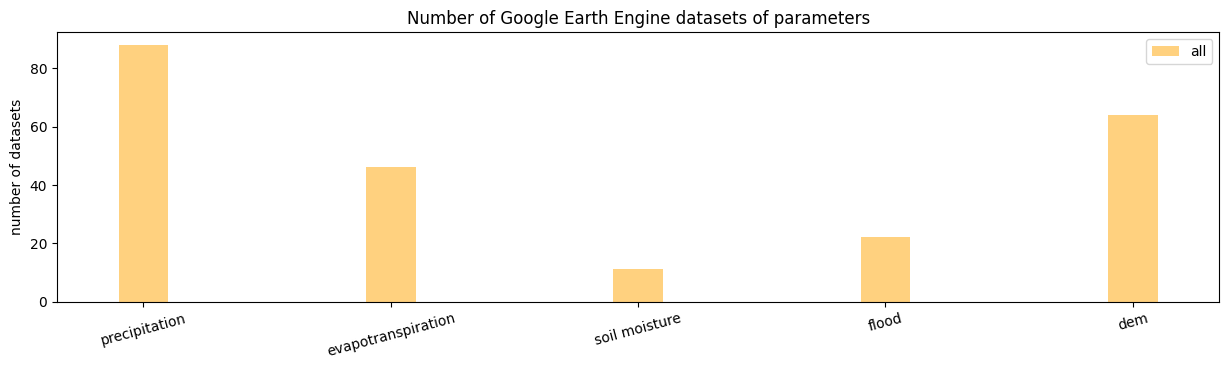

In [5]:
test = parameters_datasets("precipitation", "evapotranspiration", "soil moisture", "flood", "dem")

test.plot(figsize = (15, 3.5), 
          title = "Number of Google Earth Engine datasets of parameters", 
          kind = "bar", 
          color="orange",
          ylabel = "number of datasets",
          rot = 15, 
          width = 0.20, 
          alpha = 0.5)

plt.show()

In [6]:
basins = ee.FeatureCollection("users/jorgeluiscruzquispe7/UnidadesHidrograficas")

basins_gdf = geemap.ee_to_gdf(basins)

basins_names = basins_gdf[basins_gdf['NOMBRE'].str.startswith('Cuenca')]["NOMBRE"].tolist()

dropdown = widgets.Dropdown(options = basins_names, value = "Cuenca Rímac", description = 'Select basin:')

dropdown

Dropdown(description='Select basin:', index=96, options=('Cuenca Tarau', 'Cuenca Putumayo', 'Cuenca Yavari', '…

In [42]:
Map = geemap.Map()

srtm4 = ee.Image("USGS/SRTMGL1_003")

basin = basins.filter(ee.Filter.eq("NOMBRE", dropdown.value))

roi = basin.geometry()

basin_srtm4 = srtm4.clip(basin)

max_elevation = (basin_srtm4.reduceRegion(reducer = ee.Reducer.max(), geometry = roi, scale = 100)).getInfo()["elevation"]

min_elevation = (basin_srtm4.reduceRegion(reducer = ee.Reducer.min(), geometry = roi, scale = 100)).getInfo()["elevation"]

dem_params = {
    'max': max_elevation,
    'min': min_elevation,
    'palette': cmap.palettes.viridis
}

Map.centerObject(basin)

Map.add_basemap("TERRAIN")

Map.addLayer(ee.Image().paint(basins, 0, 2.5), {'palette': 'black'}, "Hydrographic basins of Peru")

Map.addLayer(basin_srtm4, dem_params, f"Dem {dropdown.value}")

Map.addLayer(ee.Image().paint(basin, 0, 2.5), {'palette': 'red'}, dropdown.value)

Map.add_colorbar(dem_params, label = 'elevation (meters)', background_color = "white")

Map.add_text(f"Elevation map of the {dropdown.value[7:]} basin", position = "bottomleft", 
             bg_color = "black", bold = True, fontcolor = "white")

Map

In [43]:
%%capture

dem_name = f"Dem{dropdown.value[7:]}"

download_dem(basin, dem_name)

In [44]:
stations_df = pd.read_csv("/kaggle/input/descarga-datos-de-caudales-del-senamhi/station_info.csv")
    
# stations_df.rename(columns = {'Unnamed: 0':'Estaciones'}, inplace = True)

stations_df.drop(columns = ["Unnamed: 0"], inplace = True)

stations_df

,Estación,comid,Latitud,Longitud,geometry
0,ANTAPUCRO,9073479,-12.0315,-76.6244,POINT (-76.6244 -12.0315)


In [45]:
stations_gdf = gpd.GeoDataFrame(stations_df, 
                                  geometry=gpd.points_from_xy(stations_df.Longitud, stations_df.Latitud), 
                                  crs="EPSG:4326")
stations_gdf

,Estación,comid,Latitud,Longitud,geometry
0,ANTAPUCRO,9073479,-12.0315,-76.6244,POINT (-76.62440 -12.03150)


In [46]:
Map = geemap.Map()

stations_ee = geemap.gdf_to_ee(stations_gdf)

dem_params = {
    'max': max_elevation,
    'min': min_elevation,
    'palette': cmap.palettes.viridis
}

Map.add_basemap("TERRAIN")

Map.addLayer(ee.Image().paint(basins, 0, 2.5), {'palette': 'black'}, "Hydrographic basins of Peru")

Map.addLayer(basin_srtm4, dem_params, "dem layer")

Map.addLayer(ee.Image().paint(basin, 0, 2.5), {'palette': 'red'}, "basin layer")

Map.add_colorbar(dem_params, label = 'elevation (meters)', background_color = "white")

Map.add_text(f"Elevation map of the {dropdown.value[7:]} basin", 
             position = "bottomleft", bg_color = "black", bold = True, fontcolor = "white")

Map.addLayer(stations_ee, {"color": "orange"}, "stations")

Map.addLayer(stations_ee.filter(ee.Filter.eq("Estaciones", " Tamboraque")), {"color": "red"}, "tamboraque station")

Map.centerObject(basin)

Map

In [47]:
latitude, longitude = stations_df.Latitud[0], stations_df.Longitud[0]

delimited_area, hydrographic_network, point_gdf = basin_delimitation(f"{dem_name}.tif", longitude, latitude, 2500)

In [48]:
Map = geemap.Map()

basin_srtm4_clip = srtm4.clip(delimited_area)

max_elevation = (basin_srtm4_clip.reduceRegion(reducer = ee.Reducer.max(), 
                                               geometry = delimited_area, 
                                               scale = 100)).getInfo()["elevation"]

min_elevation = (basin_srtm4_clip.reduceRegion(reducer = ee.Reducer.min(), 
                                               geometry = delimited_area, 
                                               scale = 100)).getInfo()["elevation"]

contours_lines = geemap.create_contours(basin_srtm4_clip, min_elevation, max_elevation, 100, region = delimited_area.geometry())

dem_params = {
    'max': max_elevation,
    'min': min_elevation,
    'palette': cmap.palettes.jet_r
}

Map.centerObject(delimited_area)

Map.add_basemap("TERRAIN")

Map.addLayer(ee.Image().paint(basins, 0, 2.5), {'palette': 'black'}, "Hydrographic basins of Peru")

Map.addLayer(basin_srtm4_clip, dem_params, "dem layer")

Map.addLayer(contours_lines, {"palette": "black"}, "Countor lineas", opacity = 0.35)

Map.addLayer(ee.Image().paint(delimited_area, 0, 2.5), {'palette': 'red'}, "Catchment Polygon")

Map.addLayer(hydrographic_network, {"color": "blue"}, 'hydrographic network', opacity = 0.75)

Map.addLayer(point_gdf, {"color": "green"}, 'drainage point', opacity = 0.95)

Map.add_colorbar(dem_params, label = 'Elevation (meters)', background_color = "white")

Map.add_text(f"Elevation map of the study area", position = "bottomleft", 
             bg_color = "black", bold = True, fontcolor = "white")

Map.add_legend(title = "Legend", 
               labels = ['bounded basin', 'hydrographic network', 'release point' + stations_df.iloc[station, 0]], 
               colors = ['#f50905', '#0519f5', '#41f505'], 
               position ='bottomright')

Map

In [49]:
%%capture
download_dem(delimited_area, "dem_delimitate")

<a id="section-4"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#6BB1CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 4. Time parameters to download and available information</div>

In [ ]:
year_range = range(1950, 2030)

startYear = widgets.Dropdown(
    value = 2005,
    options = year_range,
    description = 'Start Date:',
    disabled = False,
)

endYear = widgets.Dropdown(
    value = 2019,
    options = year_range,
    description = 'End Date:',
    disabled = False,
)

display(startYear)

display(endYear)

In [ ]:
start = ee.Date.fromYMD(startYear.value, 1, 1)

end = ee.Date.fromYMD(endYear.value + 1, 1, 1)

years = ee.List.sequence(startYear.value, endYear.value)

months = ee.List.sequence(1, 12)

<a id="section-5"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#6BB1CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 5. Precipitation - download - display</div>

In [ ]:
%%time
chirp_date = ee.ImageCollection(ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")\
                                                    .select(['precipitation'])\
                                                    .filterDate(start, end))
def f1(y):
    def f2(m):
        w = chirp_date.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m,'month')).sum()
        return w.set('year', y).set('month', m).set('system:time_start', ee.Date.fromYMD(y, m, 1))
    return months.map(f2)

extract_pp = years.map(f1)

df_pp = df_convert(extract_pp, roi, 5000)

In [ ]:
Map = geemap.Map()

plt.figure(figsize = (15, 2.5))

plt.bar(df_pp.index, df_pp["precipitation"], color = "blue", alpha = 0.5, width = 20, label = "data")

plt.title("Monthly Precipitation", loc = "left")

plt.ylabel("Precipitation (mm)", style = "italic")

plt.xlabel("Time", style = "italic")

plt.grid(True, c = "silver", lw = 0.75, axis = "y", linestyle = ":")

plt.legend()

plt.show()


chirp_clip = ee.Image(chirp_date.sum().clip(delimited_area))

max_pp= (chirp_clip.reduceRegion(reducer = ee.Reducer.max(), geometry = delimited_area, scale = 50)).getInfo()["precipitation"]

min_pp = (chirp_clip.reduceRegion(reducer = ee.Reducer.min(), geometry = delimited_area, scale = 50)).getInfo()["precipitation"]


params_chirps = {"palette": cmap.palettes.jet, 
                 "max": max_pp, # max_pp
                 "min": min_pp} # min_pp

Map.add_basemap("TERRAIN")

Map.addLayer(chirp_clip, 
             params_chirps, 
             'Precipitation',
             opacity = 0.5)

Map.centerObject(delimited_area)

Map.addLayer(ee.Image().paint(basins, 0, 2.5), {'palette': 'black'}, "Hydrographic basins of Peru")

Map.addLayer(ee.Image().paint(delimited_area, 0, 2.5), {'palette': 'red'}, "study area")

Map.addLayer(point_gdf, {"color": "green"}, 'drainge point', opacity = 0.95)

Map.add_colorbar(params_chirps, label = 'precipitation (mm)', background_color = "white")

Map.add_text("Accumulated precipitation map", position = "bottomleft", 
             bg_color = "black", bold = True, fontcolor = "white")
Map

In [ ]:
%%capture

img_download(extract_pp, delimited_area.geometry(), 30, "pp_img")

In [ ]:
lista_pp = glob.glob("pp_img*")

plot_image("Precipitation of the study area", 5, lista_pp)

<a id="section-6"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#6BB1CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 6. Evapotranspiration - download - display</div>

In [ ]:
%%time
#Load modis
modis_date = ee.ImageCollection(ee.ImageCollection("MODIS/006/MOD16A2")\
                                                 .select(['ET'])\
                                                 .filterDate(start, end))
                        
def f1(y):
    def f2(m):
        w = modis_date.filter(ee.Filter.calendarRange(y, y, 'year'))\
                                .filter(ee.Filter.calendarRange(m, m,'month')).sum().multiply(0.1)
        return w.set('year', y).set('month', m).set('system:time_start', ee.Date.fromYMD(y, m, 1))
    return months.map(f2)

extrac_evap = years.map(f1)

df_evap = df_convert(extrac_evap, roi, 5000)

In [ ]:
Map = geemap.Map()

plt.figure(figsize = (15, 2.5))

plt.bar(df_evap.index, df_evap["ET"], color = "green", alpha = 0.5, width = 20, label = "data")

plt.title("Monthly Evapotranspiration", loc = "left")

plt.ylabel("Evapotranspiration (mm)", style = "italic")

plt.xlabel("Time", style = "italic")

plt.grid(True, c = "silver", lw = 0.75, axis = "y", linestyle = ":")

plt.legend()

plt.show()


modis_clip = ee.Image(modis_date.sum().clip(delimited_area))

max_evap = (modis_clip.reduceRegion(reducer = ee.Reducer.max(), geometry = delimited_area, scale = 50)).getInfo()["ET"]

min_evap = (modis_clip.reduceRegion(reducer = ee.Reducer.min(), geometry = delimited_area, scale = 50)).getInfo()["ET"]

params_evap = {"palette": cmap.palettes.jet, 
                 "max": max_evap, # max_evap
                 "min": min_evap} # min_evap

Map.add_basemap("TERRAIN")

Map.addLayer(modis_clip, 
             params_evap, 
             'Evapotranspiration',
             opacity = 0.5)

Map.centerObject(delimited_area)

Map.addLayer(ee.Image().paint(basins, 0, 2.5), {'palette': 'black'}, "Hydrographic basins of Peru")

Map.addLayer(ee.Image().paint(delimited_area, 0, 2.5), {'palette': 'red'}, "study area")

Map.addLayer(point_gdf, {"color": "green"}, 'drainage point', opacity = 0.95)

Map.add_colorbar(params_evap, label = 'Evapotranspiration (mm)', background_color = "white")

Map.add_text("Accumulated evapotranspiration map", position = "bottomleft", 
             bg_color = "black", bold = True, fontcolor = "white")

Map

In [ ]:
%%capture

img_download(extrac_evap, delimited_area.geometry(), 30, "evap_img")

In [ ]:
lista_evap = glob.glob("evap_img*")

plot_image("Evapotranspiration of the study area", 5, lista_evap)

<a id="section-7"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#6BB1CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 7. Soil moisture - download - display</div>

In [ ]:
%%time
# load terraclimate
terraclimate_date = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")\
                                            .select(['soil'])\
                                            .filterDate(start, end)

def f1(y):
    def f2(m):
        w = terraclimate_date.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m,'month')).sum()
        return w.set('year', y).set('month', m).set('system:time_start', ee.Date.fromYMD(y, m, 1))
    return months.map(f2)

extract_soil = years.map(f1)

df_soil = df_convert(extract_soil, roi, 5000)

In [ ]:
Map = geemap.Map()

plt.figure(figsize = (15, 2.5))

plt.bar(df_soil.index, df_soil["soil"], color = "orange", alpha = 0.5, width = 20, label = "data")

plt.title("Monthly Soil moisture (mm)", loc = "left")

plt.ylabel("Soil moisture (mm)", style = "italic")

plt.xlabel("Time", style = "italic")

plt.grid(True, c = "silver", lw = 0.75, axis = "y", linestyle = ":")

plt.legend()

plt.show()


terraclimate_clip = ee.Image(terraclimate_date.sum().clip(delimited_area))

max_terra = (terraclimate_clip.reduceRegion(reducer = ee.Reducer.max(), geometry = delimited_area, scale = 50)).getInfo()["soil"]

min_terra = (terraclimate_clip.reduceRegion(reducer = ee.Reducer.min(), geometry = delimited_area, scale = 50)).getInfo()["soil"]

params_soil = {"palette": cmap.palettes.jet, 
                 "max": max_terra, # max_terra
                 "min": min_terra} # min_terra

Map.add_basemap("TERRAIN")

Map.addLayer(terraclimate_clip, 
             params_soil, 
             'Evapotranspiration',
             opacity = 0.5)

Map.centerObject(delimited_area)

Map.addLayer(ee.Image().paint(basins, 0, 2.5), {'palette': 'black'}, "Hydrographic basins of Peru")

Map.addLayer(ee.Image().paint(delimited_area, 0, 2.5), {'palette': 'red'}, "study area")

Map.addLayer(point_gdf, {"color": "green"}, 'punto', opacity = 0.95)

Map.add_colorbar(params_soil, label = 'Soil moisture (mm)', background_color = "white")

Map.add_text("Accumulated soil moisture map", position = "bottomleft", 
             bg_color = "black", bold = True, fontcolor = "white")

Map

In [ ]:
%%capture

img_download(extract_soil, delimited_area.geometry(), 30, "evap_soil")

In [ ]:
lista_soil = glob.glob("evap_soil*")

plot_image("Soil moisture in the study area", 5, lista_soil)

<a id="section-8"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#6BB1CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 8. ARIMA</div>

In [ ]:
flood_station = pd.read_csv("/kaggle/input/station-tamboraque/station_tamboraque.csv", index_col = 0, header = 0)

flood_station = flood_station.iloc[:-12]

data = pd.concat([df_pp, df_evap, df_soil], axis = 1)

data["flood"] = flood_station.values

data.index = pd.to_datetime(data.index).date

data.rename(columns = {"ET": "evapotranspiration", "soil": "soil_moisture"}, inplace = True)

data.index.freq = "MS"

data.head()

In [ ]:
df = data["flood"].to_frame().copy()

df.index = pd.to_datetime(df.index)

df.index.freq = "MS"

df.head()

In [ ]:
df["Logflood"] = np.log(df["flood"])

fig = plt.figure(figsize = (20, 5))

ax1, ax2 = fig.subplots(1, 2)

ax1.plot(df["flood"])

ax1.set_title("flood")

ax2.plot(df["Logflood"])

ax2.set_title("flood log");

In [ ]:
fig = plt.figure(figsize = (20, 6))

ax1, ax2, ax3 = fig.subplots(1, 3)

ax1.plot(df["flood"])

ax1.set_title("flood")

plot_acf(df["flood"], ax = ax2)

plot_pacf(df["flood"], ax = ax3);

In [ ]:
fig = plt.figure(figsize = (20, 6))

ax1, ax2, ax3 = fig.subplots(1, 3)

ax1.plot(df["flood"])

ax1.set_title("flood")

plot_acf(df["flood"], ax = ax2)

plot_pacf(df["flood"], ax = ax3);

In [ ]:
fig = plt.figure(figsize = (20, 6))

ax1, ax2, ax3 = fig.subplots(1, 3)

ax1.plot(df["Logflood"])

ax1.set_title("flood log")

plot_acf(df["Logflood"], ax = ax2)

plot_pacf(df["Logflood"], ax = ax3);

In [ ]:
Ntest = 12 # seleccionando las 12 ultimos meses

train = df.iloc[:-Ntest] 

test = df.iloc[-Ntest:] 

In [ ]:
model1 = pm.auto_arima(
    train["flood"],
    trace = True,
    suppress_warnings=True,
    seasonal = True, m = 12
)

In [ ]:
train_pred1 = model1.predict_in_sample(start = Ntest, end = -1)

test_pred1, confint1 = model1.predict(n_periods = Ntest, return_conf_int=True)

fig, ax = plt.subplots(figsize = (20, 5))

ax.set_title("hydrograph with flow predictions (ARIMA)")

ax.set_ylabel("$Flood (m^3)$")

ax.set_xlabel("Time (Months)")

ax.plot(df.index, df["flood"], label = "data", color = "blue", linestyle = "-", lw = 1.5)

ax.plot(train.index[Ntest:], train_pred1, label = "fitted", color = "red", linestyle = "--", lw = 1.5)

ax.plot(test.index, test_pred1, label = "forecast", color = "red", linestyle = "-", lw = 2.5)

ax.fill_between(
    test.index,
    confint1[:,0], confint1[:,1],
    color = "orange", alpha = 0.2
)

ax.grid(True, axis = "y", c = "silver", alpha = 0.75)

ax.legend();

In [ ]:
print(f"R^2: {(r2_score(df['flood'][-12:], test_pred1)):.4f}")

In [ ]:
model2 = pm.auto_arima(
    train["Logflood"],
    trace = True,
    suppress_warnings=True,
    seasonal = True, m = 12
)

In [ ]:
train_pred2 = model2.predict_in_sample(start = Ntest, end = -1)

test_pred2, confint2 = model2.predict(n_periods = Ntest, return_conf_int=True)

fig, ax = plt.subplots(figsize = (20, 5))

ax.set_title("hydrograph with log flow predictions (ARIMA)")

ax.set_ylabel("$log(Flood)$")

ax.set_xlabel("Time(Months)")

ax.plot(df.index, df["Logflood"], label = "data", color = "blue", linestyle = "-", lw = 1.5)

ax.plot(train.index[Ntest:], train_pred2, label = "fitted", color = "red", linestyle = "--", lw = 1.5)

ax.plot(test.index, test_pred2, label = "forecast", color = "red", linestyle = "-", lw = 2.5)

ax.fill_between(
    test.index,
    confint2[:,0], confint2[:,1],
    color = "orange", alpha = 0.2
)

ax.grid(True, axis = "y", c = "silver", alpha = 0.75)

ax.legend();

In [ ]:
print(f"R^2: {(r2_score(np.exp(df['Logflood'][-12:]), np.exp(test_pred2))):.4f}")

<a id="section-9"></a>
## <div style="color:#fff;display:fill;border-radius:10px;background-color:#6BB1CC;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 9. Neural network - assembly - prediction</div>

In [ ]:
data.head()

In [ ]:
correlation_matrix = data.corr()

plt.figure(figsize=(18, 5))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap = "Spectral_r")

plt.title("Feature Correlation Matrix")

plt.show()

In [ ]:
X = data.iloc[:,:3]

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

y = data.iloc[:,3:4].values

train_size = int(0.8 * len(X))

X_train = X_scaled[:train_size]

y_train = y[:train_size]

X_test = X_scaled[train_size:]

y_test = y[train_size:]


model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')

history = model.fit(X_train, y_train, epochs = 25, batch_size = 32, validation_data = (X_test, y_test), verbose = 0)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

In [ ]:
y_eval = model.predict(X_train)

In [ ]:
plt.figure(figsize=(15, 5))

plt.title("Hydrograph of the Tamboraque station")

plt.plot(np.arange(1, len(y_train) + 1), y_train, "b-", label = "training")

plt.plot(np.arange(1, len(y_train) + 1), y_eval, color = "orange", ls = "-", label = "training evaluation")

plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, "g-", label = "testing")

plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred)), y_pred, "r-", label = "prediction")

plt.legend()

plt.grid()

plt.show()

In [ ]:
plt.plot(history.history["loss"], label = "train loss")
plt.plot(history.history["val_loss"], label = "test loss")
plt.legend()
plt.xlabel("epochs");

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model,rankdir = "LR", show_layer_activations=True)